### Imports

In [13]:
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
from pyspark.sql.functions import col, array, concat, lit
import matplotlib.pyplot as plt



### Read the dataset

In [14]:
spark=SparkSession.builder\
    .master("local[*]")\
    .appName("LoanApproval")\
    .getOrCreate()


In [15]:
# Load data into a PySpark DataFrame
data_path = "../data/preprocessed.csv"
loan_df =  spark.read.csv(data_path, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
loan_df.show(5, truncate=False)


+------------------------------+--------------+-----+----+-----------------------------+---------+----+-----+--------+---------+-----------+----------+---------+------+------+-------------+-----------+-----------------------+----------+------------------+------------+--------------+
|Name                          |City          |State|Zip |Bank                         |BankState|Term|NoEmp|NewExist|CreateJob|RetainedJob|UrbanRural|RevLineCr|LowDoc|Sector|ApprovalMonth|IsFranchise|clean_DisbursementGross|MIS_Status|clean_ChgOffPrinGr|clean_GrAppv|clean_SBA_Appv|
+------------------------------+--------------+-----+----+-----------------------------+---------+----+-----+--------+---------+-----------+----------+---------+------+------+-------------+-----------+-----------------------+----------+------------------+------------+--------------+
|EMANUEL CHRISTIAN BOOKS AND RE|HOLYOKE       |MA   |1040|TD BANK, NATIONAL ASSOCIATION|DE       |84  |2    |0       |0        |2          |1       

### Append feature name at the beginning of each feature value

In [16]:
cols = loan_df.columns
for c in cols:
    loan_df = loan_df.withColumn(c, concat(lit(f"{c}_"), col(c)))
loan_df.show(5, truncate=False)


+-----------------------------------+-------------------+--------+--------+----------------------------------+------------+-------+-------+----------+-----------+-------------+------------+-----------+--------+---------+-----------------+-------------+--------------------------------+------------+----------------------+--------------------+----------------------+
|Name                               |City               |State   |Zip     |Bank                              |BankState   |Term   |NoEmp  |NewExist  |CreateJob  |RetainedJob  |UrbanRural  |RevLineCr  |LowDoc  |Sector   |ApprovalMonth    |IsFranchise  |clean_DisbursementGross         |MIS_Status  |clean_ChgOffPrinGr    |clean_GrAppv        |clean_SBA_Appv        |
+-----------------------------------+-------------------+--------+--------+----------------------------------+------------+-------+-------+----------+-----------+-------------+------------+-----------+--------+---------+-----------------+-------------+----------------

### Create Item Sets

In [17]:
loan_df = loan_df.select(array(*loan_df.columns).alias("items"))
loan_df.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|items                                                                                                                                                                                                                                                                                                                                                                                        |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Apply Apriori algorithm using FP-Growth

In [18]:
fp_growth = FPGrowth(itemsCol="items", minSupport=0.2, minConfidence=0.5)
model = fp_growth.fit(loan_df)

# Get frequent itemsets
frequent_itemsets = model.freqItemsets

# Generate Association Rules
association_rules = model.associationRules

In [19]:
# Print frequent itemsets
print("Frequent Itemsets:")
frequent_itemsets.show(truncate=False)

# Print association rules
print("Association Rules:")
association_rules.show(truncate=False)

Frequent Itemsets:
+-----------------------------------------------------------------------------------------+------+
|items                                                                                    |freq  |
+-----------------------------------------------------------------------------------------+------+
|[UrbanRural_1]                                                                           |294094|
|[UrbanRural_1, MIS_Status_1]                                                             |212753|
|[UrbanRural_1, MIS_Status_1, LowDoc_0]                                                   |211967|
|[UrbanRural_1, MIS_Status_1, LowDoc_0, IsFranchise_0]                                    |204948|
|[UrbanRural_1, MIS_Status_1, IsFranchise_0]                                              |205664|
|[UrbanRural_1, NewExist_0]                                                               |217150|
|[UrbanRural_1, NewExist_0, MIS_Status_1]                                                 

In [20]:
# Print association rules sorted by support
print("Association Rules sorted by Support:")
association_rules.sort(col("support").desc()).show(truncate=False)

Association Rules sorted by Support:


+---------------------------------------+------------------------+------------------+------------------+------------------+
|antecedent                             |consequent              |confidence        |lift              |support           |
+---------------------------------------+------------------------+------------------+------------------+------------------+
|[LowDoc_0]                             |[IsFranchise_0]         |0.9591190774033764|1.001228723868855 |0.8696665500795951|
|[IsFranchise_0]                        |[LowDoc_0]              |0.9078488277857683|1.001228723868855 |0.8696665500795951|
|[MIS_Status_1]                         |[clean_ChgOffPrinGr_0.0]|0.9936362928861776|1.21933110291366  |0.8138224324421505|
|[clean_ChgOffPrinGr_0.0]               |[MIS_Status_1]          |0.9986742747119406|1.2193311029136598|0.8138224324421505|
|[MIS_Status_1]                         |[IsFranchise_0]         |0.9546658205670066|0.9965799490041011|0.7819042700287328|
|[IsFran

In [21]:
# Print association rules sorted by confidence
print("Association Rules sorted by Confidence:")
association_rules.sort(col("confidence").desc()).show(truncate=False)

Association Rules sorted by Confidence:
+----------------------------------------------------------------------------+--------------+------------------+------------------+-------------------+
|antecedent                                                                  |consequent    |confidence        |lift              |support            |
+----------------------------------------------------------------------------+--------------+------------------+------------------+-------------------+
|[UrbanRural_1, NewExist_0, clean_ChgOffPrinGr_0.0]                          |[MIS_Status_1]|0.9999935583612471|1.2209418819513285|0.2537223418964903 |
|[UrbanRural_1, NewExist_0, clean_ChgOffPrinGr_0.0, LowDoc_0]                |[MIS_Status_1]|0.9999935403855098|1.2209418600038566|0.25301628187485087|
|[UrbanRural_1, NewExist_0, clean_ChgOffPrinGr_0.0, IsFranchise_0]           |[MIS_Status_1]|0.9999934090849173|1.2209416996924314|0.24797579783148047|
|[UrbanRural_1, NewExist_0, clean_ChgOffPrinGr_0

In [22]:
# Print association rules sorted by lift
print("Association Rules sorted by Lift:")
association_rules.sort(col("lift").desc()).show(truncate=False)

Association Rules sorted by Lift:


+-------------------------------------------------------------+--------------+------------------+------------------+-------------------+
|antecedent                                                   |consequent    |confidence        |lift              |support            |
+-------------------------------------------------------------+--------------+------------------+------------------+-------------------+
|[Sector_0, RetainedJob_0, RevLineCr_0, CreateJob_0]          |[UrbanRural_0]|0.9622070991585083|2.3299320272906097|0.20127613811318534|
|[Sector_0, RetainedJob_0, CreateJob_0]                       |[UrbanRural_0]|0.9621435707367666|2.329778196681182 |0.20620057988448073|
|[Sector_0, RevLineCr_0, CreateJob_0]                         |[UrbanRural_0]|0.9613143211407316|2.327770213998338 |0.20274382769520435|
|[Sector_0, RetainedJob_0, RevLineCr_0]                       |[UrbanRural_0]|0.9583290294972627|2.3205414930535393|0.2122919819693191 |
|[Sector_0, RetainedJob_0, IsFranchise_0]

In [23]:
def plot_feat1_vs_feat2(df, feat1, feat2):
    # Plot support vs. confidence
    plt.scatter(df[feat1], df[feat2], alpha=0.5)
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f"{feat1} vs {feat2}")
    plt.savefig(f'../images/association_rules/{feat1}_{feat2}.png', dpi=300, bbox_inches='tight')
    plt.show()
def plot_feat1_vs_feat2_with_feat3_shade(df, feat1, feat2, feat3):
    # Plot support vs. confidence with shading as lift
    plt.scatter(df[feat1], df[feat2], c=df[feat3], cmap='Blues', alpha=0.5)
    plt.colorbar()
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.title(f'{feat1} vs {feat2} shaded by {feat3}')
    plt.savefig(f'../images/association_rules/{feat1}_{feat2}_shade_{feat3}.png', dpi=300, bbox_inches='tight')
    plt.show()

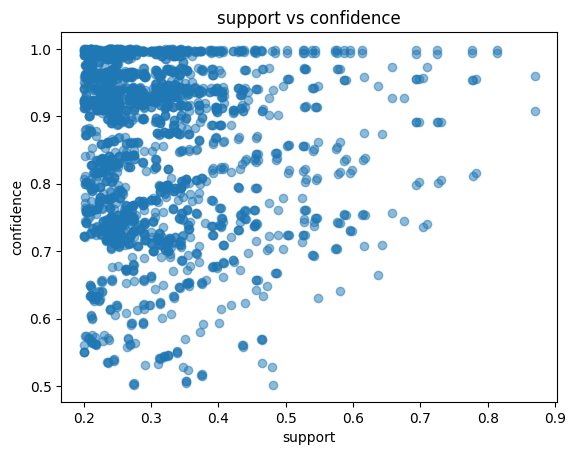

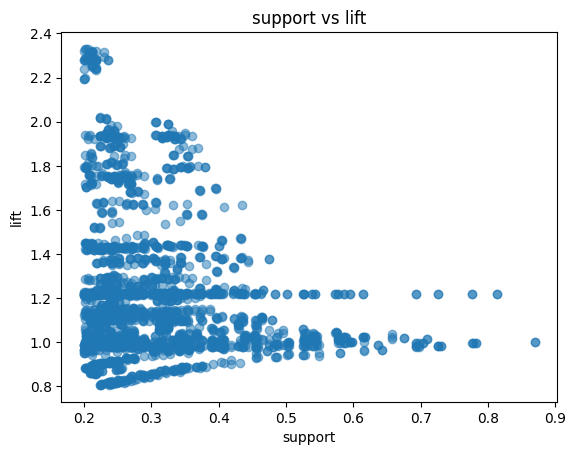

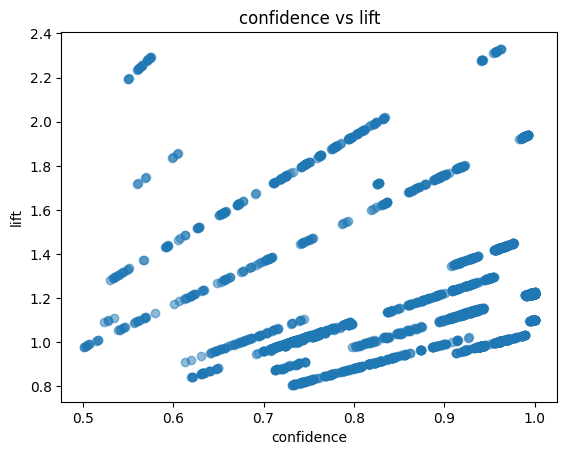

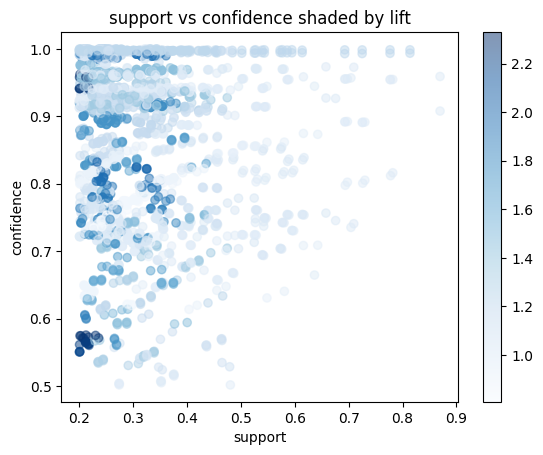

In [24]:
# Convert association rules DataFrame to pandas DataFrame to use matplotlib
association_rules_df = association_rules.toPandas()
plot_feat1_vs_feat2(association_rules_df, 'support', 'confidence')
plot_feat1_vs_feat2(association_rules_df, 'support', 'lift')
plot_feat1_vs_feat2(association_rules_df, 'confidence', 'lift')
plot_feat1_vs_feat2_with_feat3_shade(association_rules_df, 'support','confidence', 'lift')